In [1]:

# import matplotlib
# matplotlib.use('TkAgg')
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import os
import glob
import fnmatch
from collections import namedtuple, OrderedDict
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from grid_alignment import calculate_initial_compass_bearing as cibc
from bathy_common import *
from matplotlib import path
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
path_to_save ='/data/ssahu/NEP36_Extracted_Months/' #'/home/ssahu/saurav/'


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry'][:]

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']

lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

z0 = np.ma.masked_values(Z, 0)

y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

In [3]:
T_2013_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

In [4]:
lon_corner = T_2013_file.variables['nav_lon'][0,0]
lat_corner = T_2013_file.variables['nav_lat'][0,0]

In [7]:
print(lon_corner, lat_corner)

-128.857 47.3432


In [8]:
j, i = geo_tools.find_closest_model_point(lon_corner,lat_corner,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

print(j,i)

179 479


In [9]:
def tem_sal_timeseries_at_WCVI_locations(grid_scalar):#, j, i):

    temp = grid_scalar.variables['temp'][:, :, 1:, 1:]
    sal =  grid_scalar.variables['salt'][:, :, 1:, 1:]
    
    scalar_ts = namedtuple('scalar_ts', 'temp, sal')

    return scalar_ts(temp, sal)

In [11]:
scalar_ts = tem_sal_timeseries_at_WCVI_locations(T_2013_file)

In [14]:
scalar_ts[1].shape

(10, 32, 170, 170)

In [18]:
temp = np.empty((180,32,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
sal = np.empty((180,32,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))


i = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_*_grid_T_*.nc')):

    scalar_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file))
    temp[i:i+10,...] = scalar_ts[0]
    sal[i:i+10,...] = scalar_ts[1]
    i = i+10


In [ ]:
SA_loc = np.empty_like(sal)
CT_loc = np.empty_like(sal)
spic = np.empty_like(sal)
rho = np.empty_like(sal)

lat = T_2013_file.variables['nav_lat'][1:,1:]
lon = T_2013_file.variables['nav_lon'][1:,1:]

pressure_loc = gsw.p_from_z(-zlevels[:],np.mean(lat))

for t in np.arange(sal.shape[0]):
    for k in np.arange(sal.shape[1]):
        for j in np.arange(sal.shape[2]):
            for i in np.arange(sal.shape[3]):
                SA_loc[t,k,j,i] = gsw.SA_from_SP(sal[t,k,j,i], pressure_loc[k], lon[j,i], lat[j,i])
                CT_loc[t,k,j,i] = gsw.CT_from_pt(sal[t,k,j,i], temp[t,k,j,i])
                spic[t,k,j,i] = gsw.spiciness0(SA_loc[t,k,j,i],CT_loc[t,k,j,i])
#                rho_jun[t,k,j,i] = gsw.density.rho(SA_loc_jun[t,k,j,i], CT_loc_jun[t,k,j,i], pressure_loc[k])  
                rho[t,k,j,i] = gsw.density.rho(SA_loc[t,k,j,i], CT_loc[t,k,j,i], 0)


In [17]:
y_wcvi_slice.shape[0]

170

In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw
from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

In [2]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']


zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]





mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]

y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# mbathy[mbathy>32] = 32

iso_NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/2013_short_slice_NEP36_along_isopycnal_larger_offshore_rho_correct.nc')


iso_spic = iso_NEP.variables['spiciness'][...]
isot = iso_NEP.variables['isot']
nc_tools.show_variables(iso_NEP)

odict_keys(['x', 'y', 'isot', 'time_counter', 'spiciness', 'temperature', 'salinity'])


In [3]:
tmask.shape

(32, 170, 170)

In [33]:

for t in np.arange(rho.shape[0]):
    rho[t,...] = np.ma.masked_array(rho[t,...], mask= 1- tmask[...])

RuntimeError: NetCDF: HDF error

In [4]:
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,:,:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,:,:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)

In [5]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os


u_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))
v_vel = np.empty((180,zlevels.shape[0],y_wcvi_slice.shape[0]+1,x_wcvi_slice.shape[0]+1))



i = 0

for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_U*.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_vel[i:i+10,...] = vector_u[0]
    i = i+10

j = 0
for file in sorted(glob.glob('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d*grid_V*.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_vel[j:j+10,...] = vector_v[0]
    j = j+10
    

In [6]:
rho.shape

(180, 32, 170, 170)

In [7]:

t = 0
rho_0 = 26.4

u_rho_0 = np.zeros_like(iso_spic[0,0,...])
v_rho_0 = np.zeros_like(u_rho_0)

# u_tzyx = np.empty((u_vel.shape[0],zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
u_tzyx = np.empty((zlevels.shape[0],y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
v_tzyx = np.empty_like(u_tzyx)

# for t in np.arange(u_tzyx.shape[0]):

for level in np.arange(zlevels.shape[0]):
    u_tzyx[level,...], v_tzyx[level,...] = viz_tools.unstagger(u_vel[t, level,...], v_vel[t, level,...])
# rho[t,...] = np.ma.masked_array(rho[t,...], mask= 1- tmask[...])

rho_data = rho[t,...]

for j in np.arange(rho.shape[2]):
    for i in np.arange(rho.shape[3]):
        if mbathy[j,i] > 0:
#             u_rho_0[j, i] = np.interp(rho_0, rho[t,:mbathy[j, i], j, i]-1000, u_vel[t,:mbathy[j, i], j, i])
#             v_rho_0[j, i] = np.interp(rho_0, rho[t,:mbathy[j, i], j, i]-1000, v_vel[t,:mbathy[j, i], j, i])
            u_rho_0[j, i] = np.interp(rho_0, rho[t,:mbathy[j, i], j, i]-1000, u_tzyx[:mbathy[j, i], j, i])
            v_rho_0[j, i] = np.interp(rho_0, rho[t,:mbathy[j, i], j, i]-1000, v_tzyx[:mbathy[j, i], j, i])


# k = np.where(short_iso_t[:] == rho_0)

# spic_tzyx = short_spic_iso_jun[t,k[0],...]
# spic_tzyx[np.isnan(spic_tzyx)] = 0
# spic_iso = np.ma.masked_equal(spic_tzyx[0,...], 0)

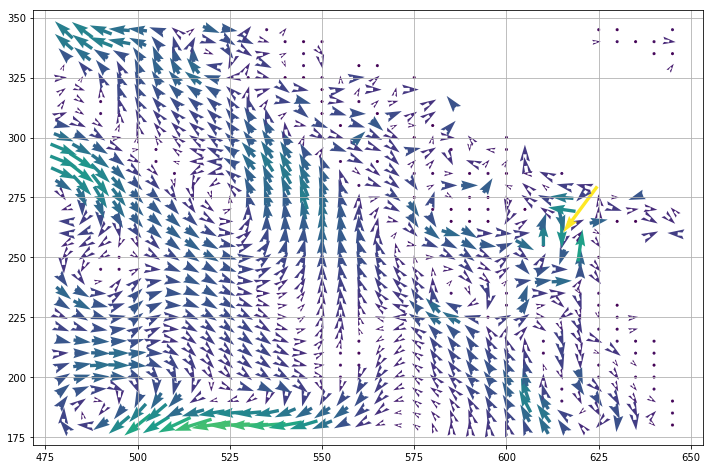

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()
arrow_step = 5
level_of_currents = 0


# u_tzyx, v_tzyx = viz_tools.unstagger(u_rho_0[...], v_rho_0[...])
u_tzyx = np.ma.masked_array(u_rho_0, mask= 1- umask[level_of_currents,:,:])
v_tzyx = np.ma.masked_array(v_rho_0, mask= 1- vmask[level_of_currents,:,:])
speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_tzyx[::arrow_step,::arrow_step], v_tzyx[::arrow_step,::arrow_step] , speeds[::arrow_step, ::arrow_step], pivot='mid', width=0.005, minshaft= 0.5)


In [24]:
u_rho_0

array([[ 26.96630859,  26.96508789,  26.9642334 , ...,  25.32104492,
         25.03149414,  23.26739502],
       [ 26.96569824,  26.96435547,  26.96350098, ...,  25.13989258,
         24.73547363,  22.7175293 ],
       [ 26.96520996,  26.96386719,  26.96276855, ...,  25.12097168,
         24.6706543 ,  22.10162354],
       ..., 
       [ 27.0435791 ,  27.04150391,  27.03979492, ...,  23.93353271,
         23.72943115,  23.30786133],
       [ 27.04211426,  27.04040527,  27.03894043, ...,  23.43280029,
         22.55053711,  23.25256348],
       [ 27.04101562,  27.03930664,  27.03796387, ...,  23.35827637,
         22.925354  ,  23.32550049]], dtype=float32)

In [25]:
u_vel

array([[[[ -3.60171087e-02,  -3.78015004e-02,  -3.95729616e-02, ...,
            8.23602546e-03,  -3.58766131e-03,  -1.39143541e-02],
         [ -3.18244286e-02,  -3.36635895e-02,  -3.56415249e-02, ...,
            5.81004098e-03,  -7.70523492e-03,  -5.32218534e-03],
         [ -2.73404215e-02,  -2.91914474e-02,  -3.15115340e-02, ...,
            4.68375132e-04,  -1.92528833e-02,   2.23877234e-03],
         ..., 
         [ -1.62802830e-01,  -1.52091250e-01,  -1.43268675e-01, ...,
            3.73679213e-02,   7.13528544e-02,   0.00000000e+00],
         [ -1.46328077e-01,  -1.34691492e-01,  -1.22778587e-01, ...,
            4.61610556e-02,  -3.50779481e-02,  -8.77925605e-02],
         [ -1.22281231e-01,  -1.13265611e-01,  -1.02347165e-01, ...,
            6.38180524e-02,   8.28335658e-02,   0.00000000e+00]],

        [[ -3.72729450e-02,  -3.90560441e-02,  -4.08261567e-02, ...,
            6.20548055e-03,  -5.42787276e-03,  -1.51719768e-02],
         [ -3.30840163e-02,  -3.49218547e-02,